***This notebook is for cold site rasters:***

  **to be resample and reprojected to RGB raster**
  
  **changing data type of the original  RGB to the data type of the reprojected rasters**
  

In [5]:
#pip install --user rioxarray


In [8]:
# importing libraries and packages 

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform

In [ ]:
# this part reprojects the canopy height and  multispectral raster to match RGB raster and create  new reprojected raster files

import rasterio
def reproject_raster(src_raster, target_raster, output_raster):
    with rasterio.open(src_raster) as src:
        src_transform = src.transform
        src_crs = src.crs
        src_width = src.width
        src_height = src.height

        with rasterio.open(target_raster) as target:
            target_transform = target.transform
            target_crs = target.crs
            target_width = target.width
            target_height = target.height

            transform, width, height = calculate_default_transform(
                src_crs, target_crs, target_width, target_height, *target.bounds)    #"calculate_default_transform" is part of rasterio library, this function calculates the transform and dimensions of the reprojected raster

            kwargs = src.meta.copy()
            kwargs.update({
                'crs': target_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(output_raster, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src_transform,
                        src_crs=src_crs,
                        dst_transform=transform,
                        dst_crs=target_crs,
                        resampling=Resampling.nearest)

def resample_rasters(input_folder):
    # Paths to the raster files
    rgb_path = os.path.join(input_folder, 'RGB.tif')
    multispectral_path = os.path.join(input_folder, 'multispectral.tif')
    chm_path = os.path.join(input_folder, 'chm.tif')    
    reprojected_multispectral_path = os.path.join(input_folder, 'multispectral_reprojected.tif')
    reprojected_chm_path = os.path.join(input_folder, 'chm_reprojected.tif')

    # Reproject the multispectral raster and canopy height  to match the RGB raster
    reproject_raster(multispectral_path, rgb_path, reprojected_multispectral_path)
    reproject_raster(chm_path, rgb_path, reprojected_chm_path)

# directories for each site
directories = ['/bsuhome/maishamaliha/scratch/cold_site_original']

# Resample rasters in their respective  directories
for directory in directories:
    resample_rasters(directory)

In [9]:
#checking after reprojection target raster have the same extent and resolution

import rasterio

# Function to get raster properties

def fun_raster_details(raster_path):
    
    ''' It takes in input raster and open the raster provide details of the raster in the first part,
    and in the second part provide details of the existing bands in the raster '''
    
    with rasterio.open(raster_path) as src:
        
        print(f"\nRaster file: {raster_path}")
        
        print(f"Number of bands: {src.count}")
        print(f"Resolution: {src.res}")
        print(f"Coordinate Reference System (CRS): {src.crs}")
        print(f"Width : {src.width}")
        print(f"Height: {src.height}")
        print(f"Affine transform: {src.transform}")
        
        for i in range(1, src.count + 1):
            band = src.read(i)
            band_meta = src.tags(i)
            band_stats = {
                'min': np.min(band),
                'max': np.max(band),
                
            }
            print(f"\nBand {i} details:")
            print(f"Data type: {band.dtype}")
            print(f"Metadata: {band_meta}")
            print(f"Statistics: {band_stats}")


In [7]:
# Get raster details from the cold folder with help of fun_raster_details(raster_path) function

def get_raster_info(input_folder):
    
    ''' This function is for getting information about rasters from a folder'''
    
    RGB_original_info = fun_raster_details("/bsuhome/maishamaliha/scratch/cold_site_original/RGB.tif")
    multi_reprojected_info = fun_raster_details("/bsuhome/maishamaliha/scratch/cold_site_original/multispectral_reprojected.tif")
    chm_reprojected_info = fun_raster_details("/bsuhome/maishamaliha/scratch/cold_site_original/chm_reprojected.tif")
    
# directories for each site
directories = ['/bsuhome/maishamaliha/scratch/cold_site_original']

# Resample rasters in their respective  directories
for directory in directories:
    get_raster_info(directory)


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/RGB.tif
Number of bands: 4
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}

Band 2 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}

Band 3 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}

Band 4 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}

Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/multispectral_reprojected.tif
Number of bands: 6
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.

In [2]:
import os
from osgeo import gdal
import numpy as np

def fun_convert_data(input_file, output_file):
    """
    Convert raster data type to float32.
    """
    raster = gdal.Open(input_file)
    if raster is None:
        raise FileNotFoundError(f"Raster file not found: {input_file}")

    driver = gdal.GetDriverByName('GTiff')
    width = raster.RasterXSize
    height = raster.RasterYSize
    num_bands = raster.RasterCount
    geotransform = raster.GetGeoTransform()
    projection = raster.GetProjection()

    # Create a new raster dataset with the desired data type (float32) and BIGTIFF option
    out_raster = driver.Create(output_file, width, height, num_bands, gdal.GDT_Float32, options=['COMPRESS=LZW', 'BIGTIFF=YES'])
    out_raster.SetGeoTransform(geotransform)
    out_raster.SetProjection(projection)

    try:
        for i in range(1, num_bands + 1):
            band = raster.GetRasterBand(i)
            data = band.ReadAsArray().astype(np.float32)
            out_band = out_raster.GetRasterBand(i)
            out_band.WriteArray(data)

        out_raster.FlushCache()
        print(f"Converted raster saved to {output_file}")
    except Exception as e:
        print(f"Error while converting raster {input_file} to {output_file}: {e}")
    finally:
        del out_raster


In [7]:
def converted_raster(input_folder):
    # Paths to the raster files
    rgb_path = os.path.join(input_folder, 'RGB.tif')
    converted_RGB_path = os.path.join(input_folder, 'converted_RGB.tif')
    # Convert the RGB raster
    fun_convert_data(rgb_path, converted_RGB_path)

# Directories for each site
directories = ['/bsuhome/maishamaliha/scratch/cold_site_original']

# Convert rasters in their respective directories
for directory in directories:
    converted_raster(directory)

/bsuhome/maishamaliha/miniforge3/envs/my_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Converted raster saved to /bsuhome/maishamaliha/scratch/cold_site_original/converted_RGB.tif


In [5]:
#lets check details of converted_RGB.tif with help of fun_raster_details(raster_path) function

fun_raster_details('/bsuhome/maishamaliha/scratch/cold_site_original/converted_RGB.tif')


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/converted_RGB.tif
Number of bands: 4
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 2 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 3 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 4 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}


In [ ]:
fun_raster_details('/bsuhome/maishamaliha/scratch/cold_site_original/RGB.tif')


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/RGB.tif
Number of bands: 4
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}

Band 2 details:
Data type: uint8
Metadata: {}
Statistics: {'min': np.uint8(0), 'max': np.uint8(255)}


In [ ]:
import os
from osgeo import gdal
import numpy as np

def stack_rasters(input_folder, output_file):
    """
    Stack multiple rasters into one raster.
    """
    # Paths to the resampled and converted raster files
    rgb_path = os.path.join(input_folder, 'converted_RGB.tif')
    reprojected_multispectral_path = os.path.join(input_folder, 'multispectral_reprojected.tif')
    reprojected_chm_path = os.path.join(input_folder, 'chm_reprojected.tif')

    # Open all the raster files with GDAL
    rasters = []
    for file in [rgb_path, reprojected_multispectral_path, reprojected_chm_path]:
        raster = gdal.Open(file)
        if raster is None:
            raise FileNotFoundError(f"Raster file not found: {file}")
        rasters.append(raster)

    # Ensure all rasters have the same dimensions
    width = rasters[0].RasterXSize
    height = rasters[0].RasterYSize
    for raster in rasters:
        if raster.RasterXSize != width or raster.RasterYSize != height:
            raise ValueError("Raster dimensions do not match")

    # Calculate total number of bands
    total_bands = sum(raster.RasterCount for raster in rasters)

    # Create a new raster dataset for the stacked output
    driver = gdal.GetDriverByName('GTiff')
    stacked = driver.Create(output_file, width, height, total_bands, gdal.GDT_Float32, options=['COMPRESS=LZW', 'BIGTIFF=YES'])

    # Set geotransform and projection
    stacked.SetGeoTransform(rasters[0].GetGeoTransform())
    stacked.SetProjection(rasters[0].GetProjection())

    # Stack the rasters
    band_index = 1
    for raster in rasters:
        for i in range(1, raster.RasterCount + 1):
            band_data = raster.GetRasterBand(i).ReadAsArray().astype(np.float32)
            stacked.GetRasterBand(band_index).WriteArray(band_data)
            band_index += 1

    # Flush cache to ensure all data is written to disk
    stacked.FlushCache()
    print(f"Layer-stacked raster saved to {output_file}")

# Example usage
input_folder = '/bsuhome/maishamaliha/scratch/cold_site_original'
output_file = os.path.join(input_folder, 'cold_stacked_raster.tif')

stack_rasters(input_folder, output_file)


/bsuhome/maishamaliha/miniforge3/envs/my_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
fun_raster_details('/bsuhome/maishamaliha/scratch/cold_site_original/cold_stacked_raster.tif')


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/cold_stacked_raster.tif
Number of bands: 11
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 2 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 3 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 4 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 5 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(-3.3788667e-06), 'max': np.float32(0.00019847872)}

Band 6 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(-4.1197254e-06

In [4]:
import os
from osgeo import gdal
import numpy as np

def stack_RGB_Chn(input_folder, output_file):
    """
    Stack converted RGB and reprojected Canopy rasters into one raster.
    """
    # Paths to the resampled and converted raster files
    rgb_path = os.path.join(input_folder, 'converted_RGB.tif')
   
    reprojected_chm_path = os.path.join(input_folder, 'chm_reprojected.tif')

    # Open all the raster files with GDAL
    rasters = []
    for file in [rgb_path, reprojected_chm_path]:
        raster = gdal.Open(file)
        if raster is None:
            raise FileNotFoundError(f"Raster file not found: {file}")
        rasters.append(raster)


    # Calculate total number of bands
    total_bands = sum(raster.RasterCount for raster in rasters)
    band = rasters[0].GetRasterBand(1)
    # Create a new raster dataset for the stacked output
    driver = gdal.GetDriverByName('GTiff')
    stacked = driver.Create(output_file,xsize = rasters[0].RasterXSize,
                      ysize= rasters[0].RasterYSize,
                      bands = total_bands,
                      eType= band.DataType,  options=['COMPRESS=LZW', 'BIGTIFF=YES'])

    # Set geotransform and projection
    stacked.SetGeoTransform(rasters[0].GetGeoTransform())
    stacked.SetProjection(rasters[0].GetProjection())

    # Stack the rasters
    band_index = 1
    for raster in rasters:
        for i in range(1, raster.RasterCount + 1):
            band_data = raster.GetRasterBand(i).ReadAsArray().astype(np.float32)
            stacked.GetRasterBand(band_index).WriteArray(band_data)
            band_index += 1

    # Flush cache to ensure all data is written to disk
    stacked.FlushCache()
    print(f"Layer-stacked raster saved to {output_file}")

# Example usage
input_folder = '/bsuhome/maishamaliha/scratch/cold_site_original'
output_file = os.path.join(input_folder, 'cold_RGB+Chn_stacked.tif')

stack_RGB_Chn(input_folder, output_file)

Layer-stacked raster saved to /bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_stacked.tif


In [8]:
fun_raster_details('/bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_stacked.tif')


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_stacked.tif
Number of bands: 5
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 2 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 3 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 4 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 5 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(nan), 'max': np.float32(nan)}


Let's write a function for visualization

In [23]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


def visualize_raster(raster_path):
    
    ''' It takes in input raster and open the raster and plot it with rasterio.plot, which provides Matplotlib functionality '''
    
    with rasterio.open(raster_path) as src:
        
        print(src.meta)
        
    # Plot with rasterio.plot, which provides Matplotlib functionality
        plt.figure(figsize=(4, 4), dpi=300)  # adjust size and resolution
        show(src,transform=src.transform)


In [11]:
#visualize_raster('/bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_stacked.tif')

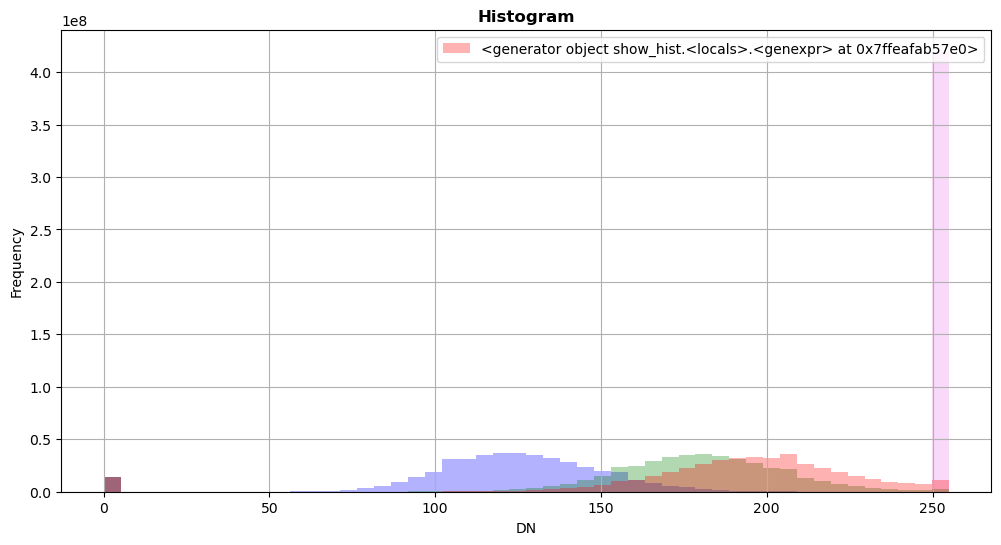

In [42]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

def plot_histogram_with_figsize(raster_path, figsize=(10, 8)):
    ''' Create a histogram figure with the desired figsize '''
    
    with rasterio.open(raster_path) as src:
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot the histogram with the custom axes
        show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, 
                  histtype='stepfilled', title="Histogram", ax=ax)
        
        plt.show()


plot_histogram_with_figsize('/bsuhome/maishamaliha/scratch/cold_site_original/converted_RGB.tif', figsize=(12, 6))


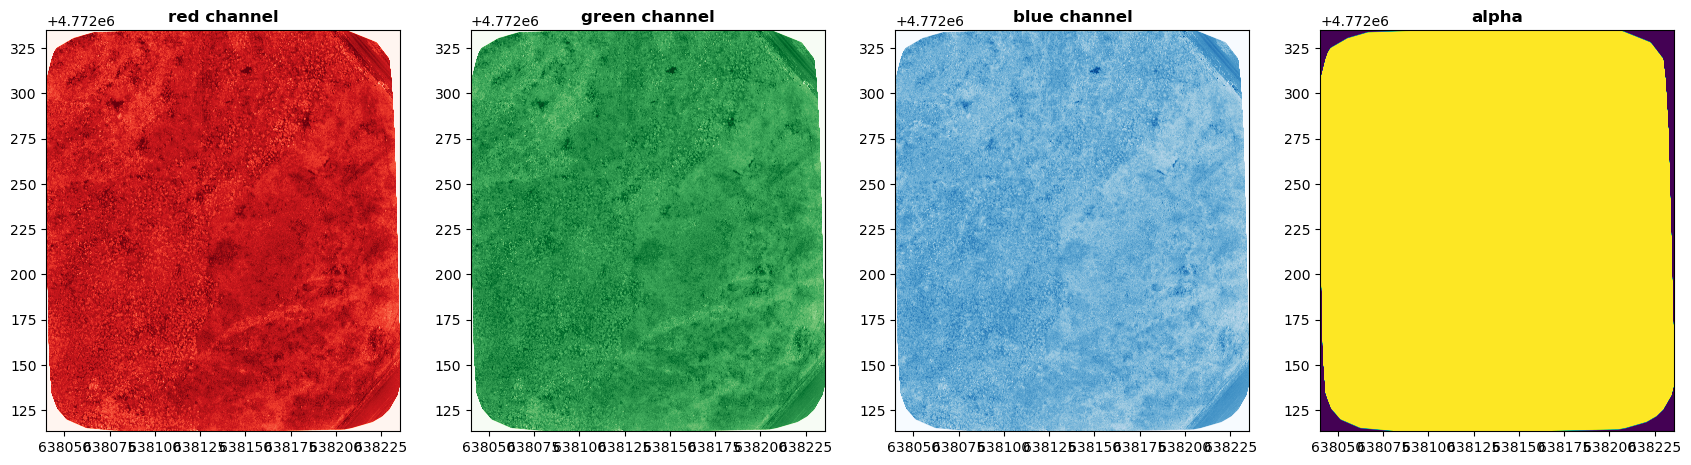

In [6]:
### Plotting RGB bands###

from matplotlib import pyplot

src = rasterio.open("cold_RGB+Chn_stacked.tif")

fig, (axr, axg, axb, axAl) = pyplot.subplots(1,4, figsize=(21,7))
show((src, 1), ax=axr, cmap='Reds', title='red channel')

show((src, 2), ax=axg, cmap='Greens', title='green channel')

show((src, 3), ax=axb, cmap='Blues', title='blue channel')

show((src, 4), ax=axAl, title='alpha')

pyplot.show()

In [7]:
import rasterio

def remove_band(input_raster_path, output_raster_path, band_to_remove):
    with rasterio.open(input_raster_path) as src:
        # Extract all bands except the one to remove
        bands = [src.read(i) for i in range(1, src.count + 1) if i != band_to_remove]
        
        # Update metadata: new band count
        new_meta = src.meta.copy()
        new_meta.update(count=len(bands))
        
        # Write the bands to the new file
        with rasterio.open(output_raster_path, 'w', **new_meta) as dst:
            for idx, band in enumerate(bands, start=1):
                dst.write(band, idx)


In [9]:
# Example usage
remove_band('/bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_stacked.tif', '/bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_4bands.tif', band_to_remove=4)

In [16]:
fun_raster_details('/bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_4bands.tif')


Raster file: /bsuhome/maishamaliha/scratch/cold_site_original/cold_RGB+Chn_4bands.tif
Number of bands: 4
Resolution: (0.009999936418225278, 0.009999808547587849)
Coordinate Reference System (CRS): EPSG:32611
Width : 19549
Height: 22175
Affine transform: | 0.01, 0.00, 638040.09|
| 0.00,-0.01, 4772335.03|
| 0.00, 0.00, 1.00|

Band 1 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 2 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 3 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(0.0), 'max': np.float32(255.0)}

Band 4 details:
Data type: float32
Metadata: {}
Statistics: {'min': np.float32(nan), 'max': np.float32(nan)}


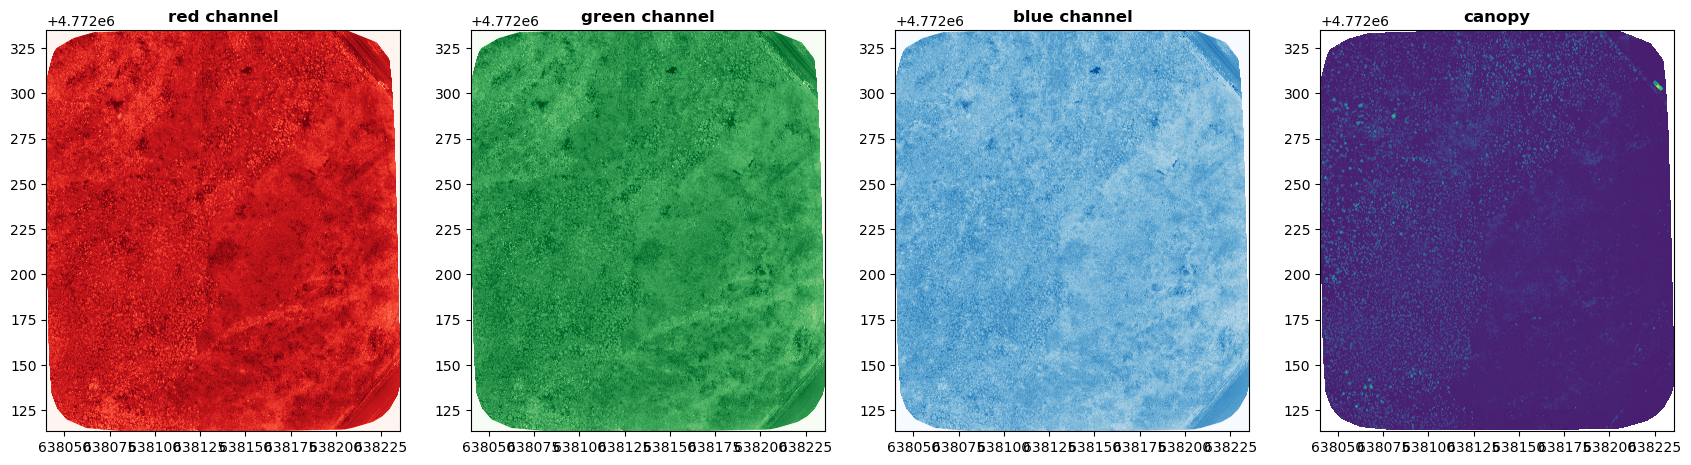

In [21]:
### Plotting RGB and canopy bands###

from matplotlib import pyplot

src = rasterio.open("cold_RGB+Chn_4bands.tif")

fig, (axr, axg, axb, axC) = pyplot.subplots(1,4, figsize=(21,7))
show((src, 1), ax=axr, cmap='Reds', title='red channel')

show((src, 2), ax=axg, cmap='Greens', title='green channel')

show((src, 3), ax=axb, cmap='Blues', title='blue channel')

show((src, 4), ax=axC, title='canopy')

pyplot.show()

# loading geojson file that has the plants point data and creating square box around that

In [5]:
# reading geojson with geopanda

import geopandas as gdp

plant_df= gdp.read_file("plant_data.geojson")
plant_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24568 entries, 0 to 24567
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        24568 non-null  object  
 1   CID       24568 non-null  int32   
 2   Class     24568 non-null  object  
 3   Species   24568 non-null  object  
 4   Ht_gt_25  24568 non-null  int32   
 5   notes     12415 non-null  object  
 6   site      24568 non-null  object  
 7   x         24568 non-null  float64 
 8   y         24568 non-null  float64 
 9   geometry  24568 non-null  geometry
dtypes: float64(2), geometry(1), int32(2), object(5)
memory usage: 1.7+ MB


In [12]:
# creating square box around plant points using Shapely libray (pyhton doesn't have built-in suqare buffer like R, so we need to write a manual code for that)

from shapely.geometry import box


def square_buffer(geometry, distance):
    ''' Function to create a square buffer around the plant points'''
    
    minx, miny, maxx, maxy = geometry.bounds
    return box(minx - distance, miny - distance, maxx + distance, maxy + distance)

# applying the square buffer function to each geometry
pt_buffed = plant_df.copy()
pt_buffed['geometry'] = plant_df['geometry'].apply(lambda geom: square_buffer(geom, 1))

#saving the buffered data to a new file
pt_buffed.to_file("plant_data_buffered.geojson", driver="GeoJSON")


In [13]:
#loading the newly created buffered data
plant_data_buffered= gdp.read_file("plant_data_buffered.geojson")

#next step is to extracting only the sites that match the site that we are currently working with(Cold), 
#note that the plant_data.geojson has all the 14 sites data in it.

cold_buff= plant_data_buffered[plant_data_buffered['site']=='Cold']


In [14]:
##saving the cold_buff buffered data to a new file 
cold_buff.to_file("cold_buff.geojson", driver="GeoJSON")


ID  CID  Class Species  Ht_gt_25 notes  site           x  \
0  Cold_0001    2  Shrub   ARTRW         1        Cold  638086.311   
1  Cold_0002    2  Shrub    ARAR         1        Cold  638083.887   
2  Cold_0003    2  Shrub    PUTR         1        Cold  638083.557   
3  Cold_0004    2  Shrub   ARTRW         1        Cold  638081.652   
4  Cold_0005    2  Shrub    ARAR         1        Cold  638086.720   

             y                                           geometry  
0  4772293.964  POLYGON ((638087.311 4772292.964, 638087.311 4...  
1  4772293.420  POLYGON ((638084.887 4772292.42, 638084.887 47...  
2  4772293.656  POLYGON ((638084.557 4772292.656, 638084.557 4...  
3  4772290.803  POLYGON ((638082.652 4772289.803, 638082.652 4...  
4  4772290.645  POLYGON ((638087.72 4772289.645, 638087.72 477...

In [3]:
cold_buff= gdp.read_file("cold_buff.geojson")

In [4]:
cold_buff.info()
print(cold_buff['Species'].value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2582 entries, 0 to 2581
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        2582 non-null   object  
 1   CID       2582 non-null   int32   
 2   Class     2582 non-null   object  
 3   Species   2582 non-null   object  
 4   Ht_gt_25  2582 non-null   int32   
 5   notes     2582 non-null   object  
 6   site      2582 non-null   object  
 7   x         2582 non-null   float64 
 8   y         2582 non-null   float64 
 9   geometry  2582 non-null   geometry
dtypes: float64(2), geometry(1), int32(2), object(5)
memory usage: 181.7+ KB
Species
ARAR       2157
ARTRW       264
Dead         57
ARTR         28
Cirsium      21
ERSP         20
PUTR         13
ELEL         12
ERNA          3
BAHO          3
ARTR4         2
Unknown       1
Aster         1
Name: count, dtype: int64


<Axes: >

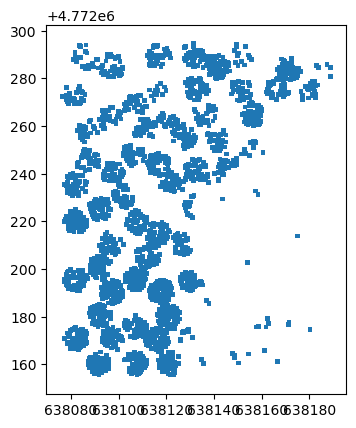

In [6]:
import matplotlib.pyplot as plt
cold_buff.plot()


In [13]:
#randomly visualizing one cropped raster

import rasterio
import matplotlib.pyplot as plt

def viz_raster(raster_path):
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Read the first band (assuming it's a single-band raster)
        raster_data = src.read(4)
        
        # Get the raster's metadata
        meta = src.meta
    
    # Plot the raster data using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data)  # Use a colormap that suits your data
    plt.colorbar(label='Raster Values')
    plt.title(f"Visualization of {raster_path}")
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

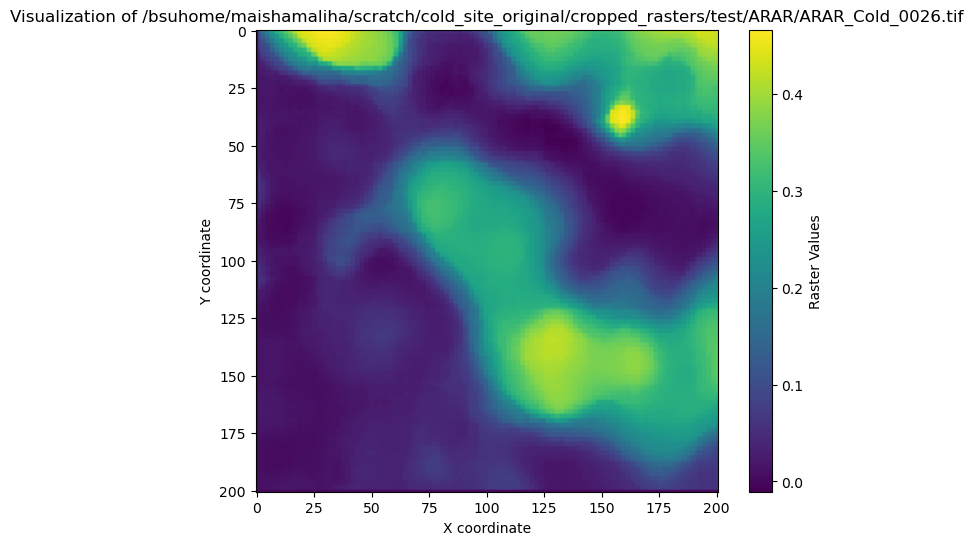

In [14]:
 viz_raster("/bsuhome/maishamaliha/scratch/cold_site_original/cropped_rasters/test/ARAR/ARAR_Cold_0026.tif")

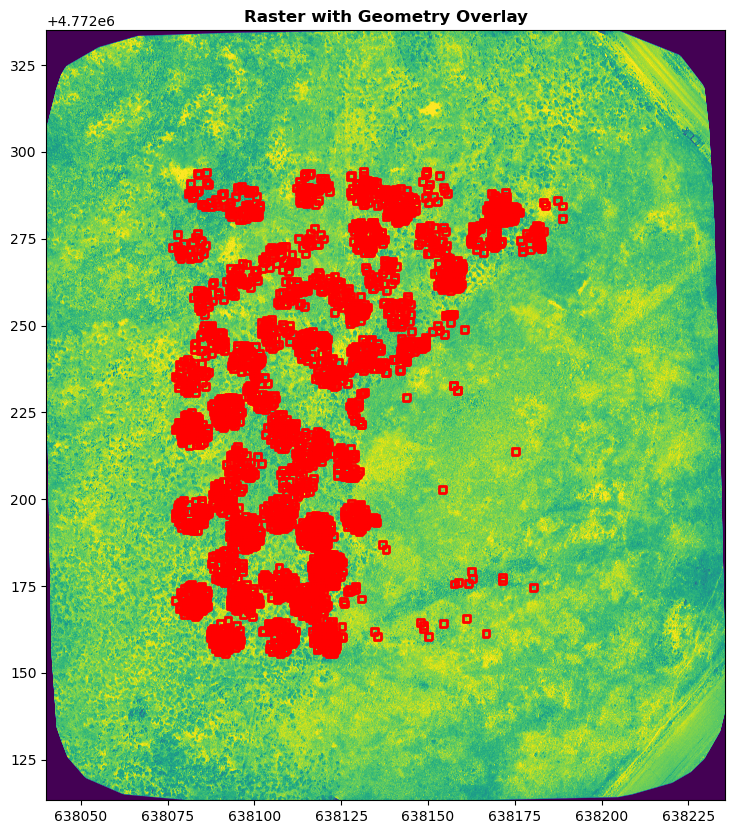

In [4]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
#from rasterio.plot import show_bounds


cold_buff = gpd.read_file('cold_buff.geojson')  


raster_path = 'cold_RGB_Chn_4bands.tif'
with rasterio.open(raster_path) as src:
   
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title='Raster with Geometry Overlay')

    # cold_buff on top of the raster
    cold_buff.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

    
    plt.show()


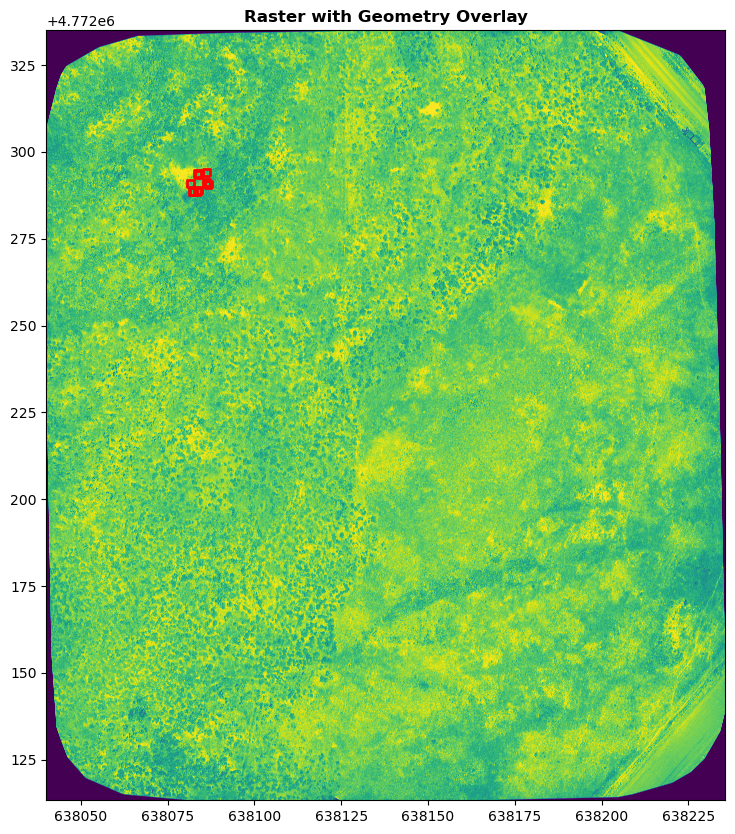

In [5]:
cold_buff = gpd.read_file('cold_buff.geojson')  
# first 10 rows
cold_buff_first_10 = cold_buff.head(10)

# save the new \ to a new GeoJSON file
cold_buff_first_10.to_file('cold_buff_first_10.geojson', driver='GeoJSON')
cold_buff_first_10 = gpd.read_file('cold_buff_first_10.geojson')

raster_path = 'cold_RGB_Chn_4bands.tif'
with rasterio.open(raster_path) as src:
   
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title='Raster with Geometry Overlay')

    # cold_buff on top of the raster
    cold_buff_first_10.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

    
    plt.show()
